# Assignment
- Start a clean notebook, or continue with yesterday's assignment notebook.
- Continue to participate in our Kaggle competition with the Tanzania Waterpumps data. 
- Do more exploratory data analysis, data cleaning, feature engineering, and feature selection.
- Try a Random Forest Classifier. 
- Try Ordinal Encoding.
- Submit new predictions.
- Commit your notebook to your fork of the GitHub repo.

## Stretch Goals
- Create visualizations and share on Slack.
- Read more about decision trees and tree ensembles. You can start with the links at the top & bottom of this notebook:

In [159]:
# Importing data and doing train/val split...

import pandas as pd
from sklearn.model_selection import train_test_split

LOCAL = '../data/tanzania/'

train = pd.merge(pd.read_csv(LOCAL + 'train_features.csv'),
                 pd.read_csv(LOCAL + 'train_labels.csv'))
test = pd.read_csv(LOCAL + 'test_features.csv')
sample_submission = pd.read_csv(LOCAL + 'sample_submission.csv')

train, val = train_test_split(
    train, train_size=0.80, test_size=0.20, 
    stratify=train['status_group'], random_state=42)

train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

In [160]:
# Exploring train data...

import pandas_profiling

train.profile_report()

quality_group  water_quality     
colored        coloured                403
fluoride       fluoride                165
               fluoride abandoned       14
good           soft                  40598
milky          milky                   658
salty          salty                  3903
               salty abandoned         276
unknown        unknown                1503
dtype: int64


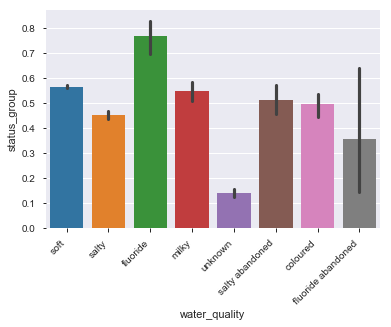

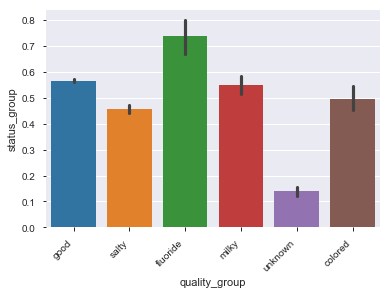

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

water_quality_cols = ['water_quality',
                      'quality_group']

print(train.groupby(water_quality_cols[::-1]).size())

for feature in water_quality_cols:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    sns.barplot(x=train[feature], y=train['status_group']=='functional');
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
# 'fluoride' and 'fluoride abandoned' are not similar
# 'salty' and 'salty abandoned' are similar

# Plan:
# Keep water_quality, but collapse 'fluoride abandoned' into 'fluoride'
# Drop quality_group

waterpoint_type_group  waterpoint_type            
cattle trough          cattle trough                     89
communal standpipe     communal standpipe             22778
                       communal standpipe multiple     4864
dam                    dam                                5
hand pump              hand pump                      14015
improved spring        improved spring                  631
other                  other                           5138
dtype: int64


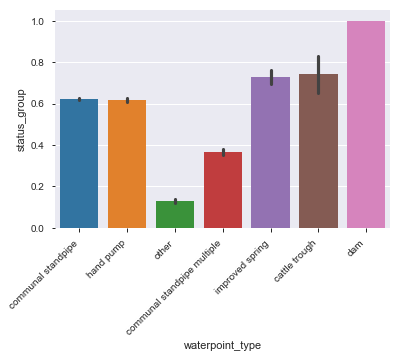

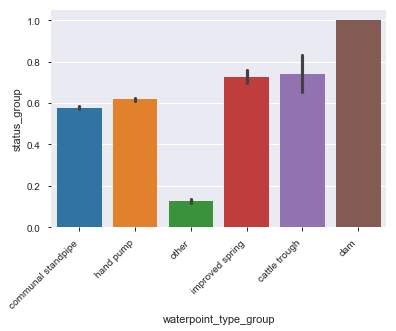

In [162]:
waterpoint_type_cols = ['waterpoint_type',
                        'waterpoint_type_group']

print(train.groupby(waterpoint_type_cols[::-1]).size())

for feature in waterpoint_type_cols:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    sns.barplot(x=train[feature], y=train['status_group']=='functional');
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
# 'communal standpipe' and 'communal standpipe multiple' are not similar

# Plan:
# Keep waterpoint_type
# Drop waterpoint_type_group

management_group  management      
commercial        company               534
                  private operator     1566
                  trust                  63
                  water authority       731
other             other                 669
                  other - school         80
parastatal        parastatal           1397
unknown           unknown               453
user-group        vwc                 32449
                  water board          2343
                  wua                  2046
                  wug                  5189
dtype: int64


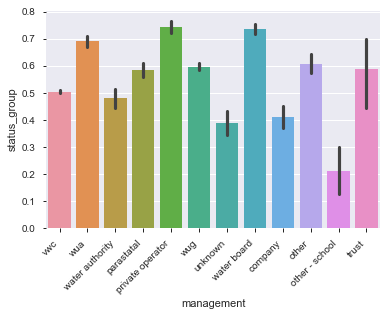

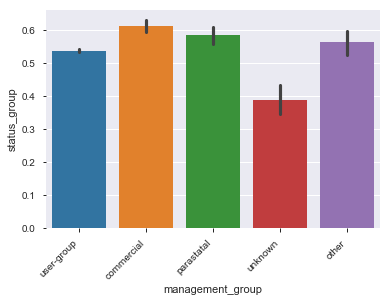

In [163]:
management_cols = ['management',
                   'management_group']

print(train.groupby(management_cols[::-1]).size())

for feature in management_cols:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    sns.barplot(x=train[feature], y=train['status_group']=='functional');
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
# both 'commercial' and 'user-group' gloss over a lot of differences

# Plan:
# Keep management
# Drop management_group

source_class  source_type           source              
groundwater   borehole              hand dtw                  698
                                    machine dbh              8813
              shallow well          shallow well            13507
              spring                spring                  13620
surface       dam                   dam                       518
              rainwater harvesting  rainwater harvesting     1859
              river/lake            lake                      586
                                    river                    7685
unknown       other                 other                     175
                                    unknown                    59
dtype: int64


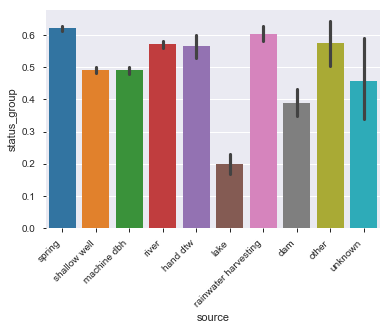

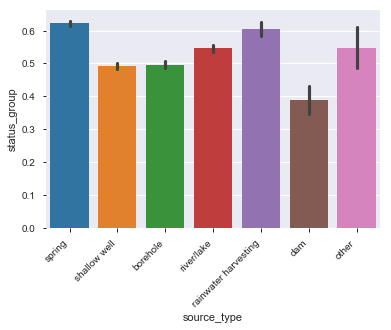

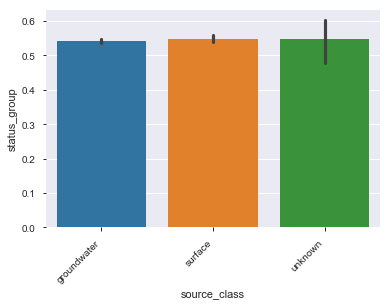

In [164]:
source_cols = ['source',
               'source_type',
               'source_class']

print(train.groupby(source_cols[::-1]).size())

for feature in source_cols:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    sns.barplot(x=train[feature], y=train['status_group']=='functional');
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
# 'hand dtw' and 'machine dbh' are not sufficiently similar
# 'river' and 'lake' are not similar
# consolidations in source_class cover over a lot of differences

# Plan:
# Keep source
# Drop source_type
# Drop source_class

extraction_type_class  extraction_type_group  extraction_type          
gravity                gravity                gravity                      21448
handpump               afridev                afridev                       1435
                       india mark ii          india mark ii                 1928
                       india mark iii         india mark iii                  73
                       nira/tanira            nira/tanira                   6526
                       other handpump         other - mkulima/shinyanga        1
                                              other - play pump               65
                                              other - swn 81                 184
                                              walimi                          42
                       swn 80                 swn 80                        2930
motorpump              mono                   mono                          2261
                       other motorpum

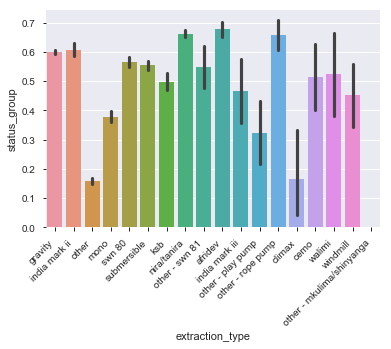

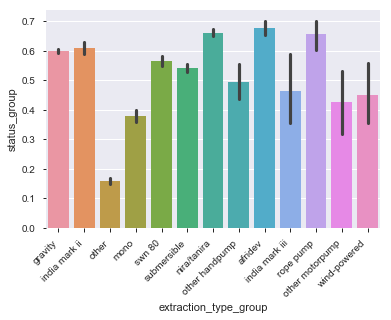

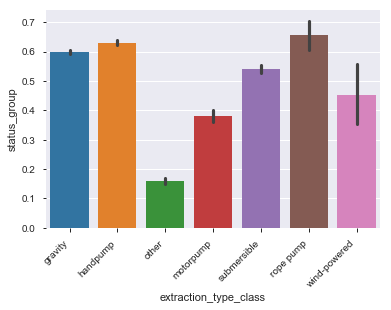

In [165]:
extraction_type_cols = ['extraction_type',
                        'extraction_type_group',
                        'extraction_type_class']

print(train.groupby(extraction_type_cols[::-1]).size())

for feature in extraction_type_cols:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    sns.barplot(x=train[feature], y=train['status_group']=='functional');
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
# 'cemo' and 'climax' are not similar
# 'submersible' and 'ksb' are similar
# 'other - swn 81' is similar to 'walimi'
# 'other - swn 81' is not similar to 'other - play pump'
# 'other - play pump' is similar to 'other'
# 'other - mkulima/shinyanga', the least common, could be lumped into 'other'
# 'climax', the second least common, could be lumped into 'other'
# consolidations in extraction_type_class cover over a lot of differences

# Plan:
# Keep extraction_type, but...
# (i) collapse 'ksb' into 'submersible'
# (ii) collapse 'other - swn 81' and 'walimi' into 'other handpump'
# (iii) collapse 'other - play pump', 'other - mkulima/shinyanga',
#       and 'climax' into 'other'
# Drop extraction_type_group
# Drop extraction_type_class

In [166]:
print(train.groupby(['scheme_management', 'management']).size(), '\n')
print(train.groupby(['management', 'scheme_management']).size())

# While scheme_management and management take similar values, they are not
# the same - the operator is not always the manager and vice versa

# Plan:
# Keep scheme_management
# Keep management

scheme_management  management      
Company            company               523
                   other                   2
                   parastatal             19
                   private operator      181
                   vwc                    98
                   wug                     1
None               vwc                     1
Other              other                 408
                   parastatal              1
                   private operator       52
                   trust                   1
                   unknown                 6
                   vwc                    31
                   water authority        16
                   wug                    88
Parastatal         parastatal           1232
                   private operator       46
                   unknown                 3
                   vwc                    38
                   water authority         1
Private operator   company                 2
                   

In [167]:
train.groupby(['region_code', 'region']).size()

# region_code 18 covers both Kagera and Lindi, which are non-adjacent
# region_code 11 covers both Iringa and Shinyanga, which are non-adjacent

# Plan:
# Keep region
# Drop region_code

region_code  region       
1            Dodoma           1768
2            Arusha           2424
3            Kilimanjaro      3512
4            Tanga            2006
5            Morogoro         3238
             Tanga              23
6            Pwani            1290
7            Dar es Salaam     631
8            Lindi             241
9            Mtwara            315
10           Ruvuma           2090
11           Iringa           4250
             Shinyanga           5
12           Mbeya            3703
13           Singida          1678
14           Shinyanga          12
             Tabora           1586
15           Rukwa            1440
16           Kigoma           2276
17           Mwanza             46
             Shinyanga        3955
18           Kagera           2615
             Lindi               7
19           Mwanza           2439
20           Mara             1560
21           Manyara          1284
24           Arusha            262
40           Pwani          

In [168]:
train.groupby(['district_code', 'region']).size()

# district_codes reused for districts in different regions

# Plan:
# drop district_codes

district_code  region       
0              Dodoma             19
1              Arusha            155
               Dar es Salaam      68
               Dodoma            715
               Iringa            589
               Kagera            611
               Kigoma            724
               Kilimanjaro       463
               Lindi               1
               Manyara           444
               Mara              140
               Mbeya             237
               Morogoro          895
               Mtwara            326
               Mwanza            332
               Pwani             786
               Rukwa             534
               Ruvuma            331
               Shinyanga         948
               Singida           444
               Tabora            467
               Tanga             562
2              Arusha            966
               Dar es Salaam     389
               Iringa            427
               Kagera            391
         

In [169]:
print(train['subvillage'].nunique())

train.groupby(['subvillage', 'region']).size()

# Cardinality extremely high
# Subvillage names reused for subvillages in different regions
# GPS coordinates already give specific location

# Plan:
# drop subvillage

17231


subvillage            region       
##                    Kagera             1
'A' Kati              Mara               1
1                     Mwanza           106
14Kambalage           Mwanza             4
18                    Tabora             1
19                    Tabora             3
20                    Tabora             1
22B                   Tabora             1
23B                   Tabora             1
42                    Tabora             1
43                    Tabora             1
44                    Tabora             3
45                    Tabora             1
47                    Tabora             1
48                    Tabora             1
49                    Tabora             1
52 A                  Tabora             1
53 A                  Tabora             2
53 B                  Tabora             1
54                    Tabora             1
58 B                  Tabora             2
61 A                  Tabora             1
61 B              

In [170]:
print(train['ward'].nunique())

pd.set_option('display.max_rows', 500)
train.groupby(['ward', 'region']).size()

# Cardinality quite high
# Ward names reused for wards in different regions
# GPS coordinates already give specific location

# Plan:
# drop ward

2082


ward                     region       
Aghondi                  Singida            9
Akheri                   Arusha            32
Arash                    Arusha             8
Arri                     Manyara           17
Arusha Chini             Kilimanjaro       43
Babayu                   Dodoma             8
Badi                     Shinyanga         23
Badugu                   Mwanza            15
Bahi                     Dodoma            15
Balangidalalu            Manyara           15
Baleni                   Pwani             15
Bangata                  Arusha            29
Bangwe                   Kigoma             7
Baraa                    Arusha             2
Bargish                  Manyara           11
Bariadi                  Shinyanga         11
Barikiwa                 Lindi              9
Barray                   Arusha            20
Bashay                   Manyara           23
Bashinet                 Manyara           13
Bassodesh                Manyara         

In [171]:
print(train['lga'].nunique())

pd.set_option('display.max_rows', 500)
train.groupby(['lga', 'region']).size()

# Cardinality manageable with ordinal encoding
# Possibly redundant with longitude and latitude, but worth a try

# Plan:
# Keep lga

124


lga               region       
Arusha Rural      Arusha            997
Arusha Urban      Arusha             54
Babati            Manyara           414
Bagamoyo          Pwani             797
Bahi              Dodoma            188
Bariadi           Shinyanga         931
Biharamulo        Kagera            335
Bukoba Rural      Kagera            391
Bukoba Urban      Kagera             71
Bukombe           Shinyanga         404
Bunda             Mara              352
Chamwino          Dodoma            278
Chato             Kagera            174
Chunya            Mbeya             237
Dodoma Urban      Dodoma            290
Geita             Mwanza            384
Hai               Kilimanjaro       495
Hanang            Manyara           220
Handeni           Tanga             199
Igunga            Tabora            275
Ilala             Dar es Salaam     389
Ileje             Mbeya             192
Ilemela           Mwanza            117
Iramba            Singida           444
Iringa R

In [172]:
print(train['scheme_name'].nunique())

pd.set_option('display.max_rows', 500)
train.groupby(['scheme_name', 'scheme_management']).size()

# Cardinality quite high
# scheme_name reused for schemes under different scheme_management
# scheme_management already tells us a lot about who operates waterpoint

# Plan:
# Drop scheme_name

2563


scheme_name                            scheme_management
14 Kambarage                           VWC                    6
A                                      Parastatal             4
                                       VWC                    2
                                       WUA                   12
                                       Water Board           14
ADP                                    Water authority        8
ADP Simbo                              Private operator       9
                                       Water authority       10
ADRA                                   VWC                    6
AIC                                    VWC                    1
AMREF                                  WUG                    1
AMRSF                                  WUG                    1
AUWASA Pipe scheme                     Water authority        1
AUWASA pipe scheme                     Water authority        5
African Barrick Gold                   VWC     

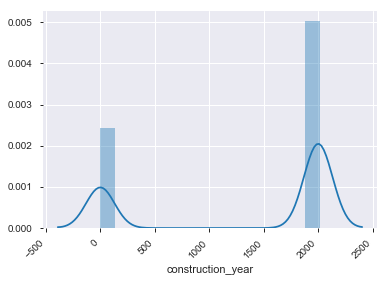

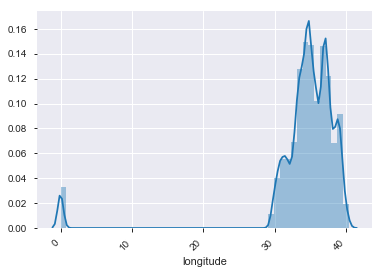

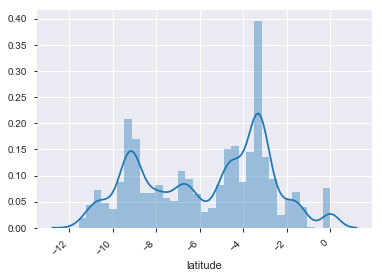

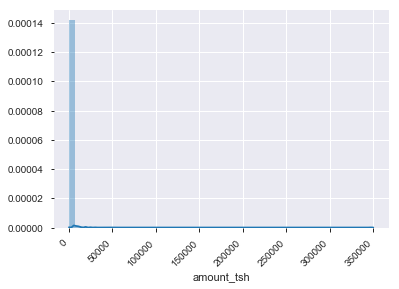

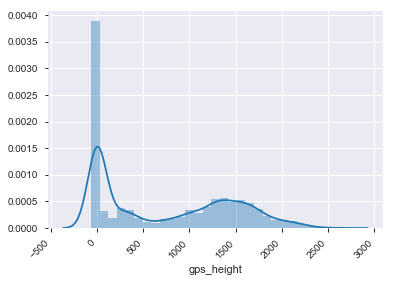

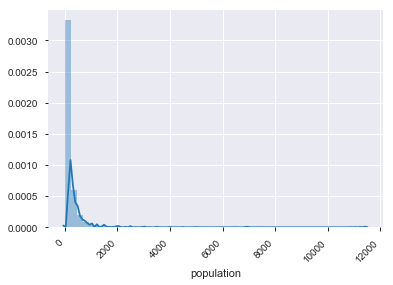

In [173]:
to_plot = ['construction_year',
           'longitude',
           'latitude',
           'amount_tsh',
           'gps_height',
           'population']

for feature in to_plot:
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    sns.distplot(train[train['status_group']=='functional'][feature]);
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
# These features all seem to have zeros representing Nans; see the spikes

# Plan:
# For each of these features, replace zeros with means

In [174]:
# Wrangling data...

import numpy as np

def wrangle(data):
    """Wrangles train, validate, and test sets in the same way"""
    data = data.copy()
    
    # When latitude has small values near zero outside Tanzania, 
    # treating these values like zero...
    data['latitude'] = data['latitude'].replace(-2e-08, 0)
        
    # Replacing zeros used to represent nulls with actual nulls...
    cols_with_zeros = ['construction_year',
                       'longitude',
                       'latitude',
                       'amount_tsh',
                       'gps_height',
                       'population',
                      ]
    for col in cols_with_zeros:
        data[col] = data[col].replace(0, np.nan)
        data[col] = data[col].fillna(data[col].mean())
    
    # Converting date_recorded to datetime format...
    data['date_recorded'] = pd.to_datetime(data['date_recorded'], 
                                           infer_datetime_format=True)
    
    # Creating year_recorded from date_recorded...
    data['year_recorded'] = data['date_recorded'].dt.year
    # Creating month_recorded from date_recorded...
    data['month_recorded'] = data['date_recorded'].dt.month
    # Engineering years_since_construction
    data['years_since_construction'] = data[
        'year_recorded'] - data['construction_year']

    # Encoding boolean features as ordinals...
    cols_with_bools = ['public_meeting',
                       'permit']
    for col in cols_with_bools:
        data[col] = data[col].replace({True: 1, False: 0})
        # Filling NaNs with mean, though not a perfect solution with bools...
        data[col] = data[col].fillna(data[col].mean())
    
    # Handling NaNs in scheme_management...
    data['scheme_management'] = data['scheme_management'].fillna('MISSING')

    # Simplifying water_quality...
    data['water_quality'] = data['water_quality'].replace(
        'fluoride abandoned', 'fluoride')
    
    # Simplifying extraction_type, part 1/3...
    data['extraction_type'] = data['extraction_type'].replace(
        'ksb', 'submersible')    
    # ...part 2/3...
    data['extraction_type'] = data['extraction_type'].replace(
        ['other - swn 81', 'walimi'], 'other handpump')    
    # ...and part 3/3...
    data['extraction_type'] = data['extraction_type'].replace(
        ['other - play pump', 'other - mkulima/shinyanga', 'climax'],
        'other')

    # Dropping columns...
    cols_to_drop = ['recorded_by', # only has one value
                    'quantity_group', # duplicate of quantity
                    'num_private', # virtually all zeros
                    'payment_type', # essentially a duplicate of payment
                    'quality_group', # see modified water_quality
                    'waterpoint_type_group', # see waterpoint_type
                    'management_group', # see management
                    'source_type', # see source
                    'source_class', # see source
                    'extraction_type_group', # see modified extraction_type
                    'extraction_type_class', # see modified extraction_type
                    'region_code', # see region
                    'district_code', # does not pick out contiguous region
                    'subvillage', # see longitude and latitude, plus lga
                    'ward', # see longitude and latitude, plus lga
                    'scheme_name', # see scheme_management
                    'date_recorded', # see year_recorded and month_recorded
                    'wpt_name', # names of waterpoints are not general
                   ]
    for col in cols_to_drop:
        data = data.drop(columns=col)
    
    return data

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [175]:
# Selecting features...

target = 'status_group'

# Since we don't want to use the target or id as features...
train_features = train.drop(columns=[target, 'id'])

# Getting numeric features...
numeric_features = train_features.select_dtypes(
    include='number').columns.tolist()

# Getting categorical features with cardinality <= 25...
cardinality = train_features.select_dtypes(exclude='number').nunique()
categorical_features = cardinality[cardinality <= 25].index.tolist()

# Combining lists of numeric and categorical features...
features = numeric_features + categorical_features

Train Accuracy Score: 0.7391624579124579
Validation Accuracy Score: 0.737037037037037


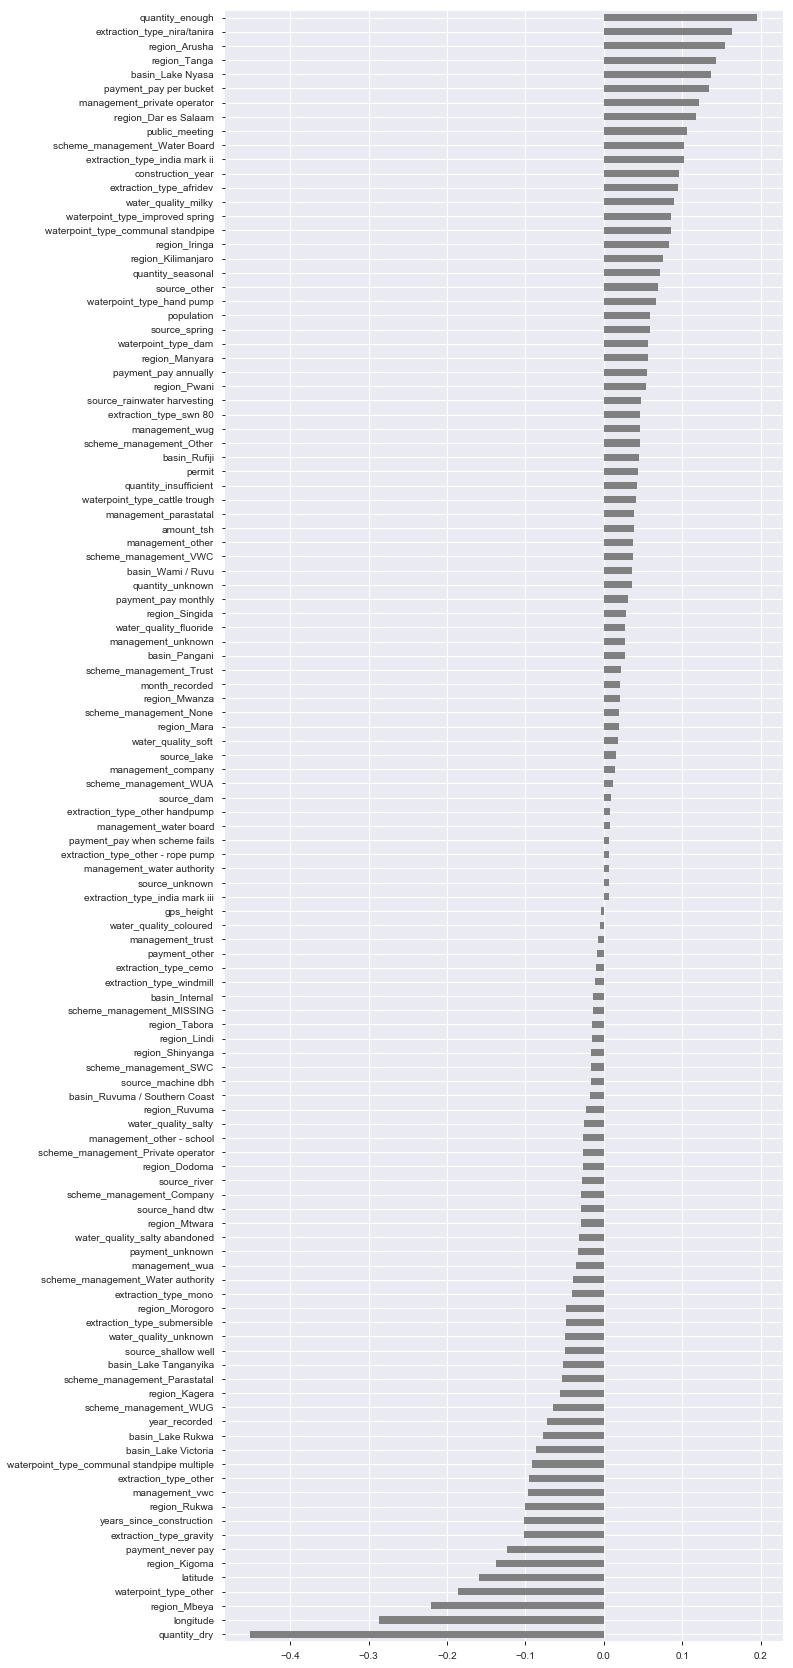

In [176]:
# Using a logistic regression and getting accuracy and coefficients...

import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Arranging data into X features matrix and y target vector ...
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# One-Hot Encoding categorical features...
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaling data...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fitting model on train data, scoring accuracy, predicting on test data...
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting coefficients...
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns.tolist())
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.7244107744107744
Validation Accuracy Score: 0.7218013468013468


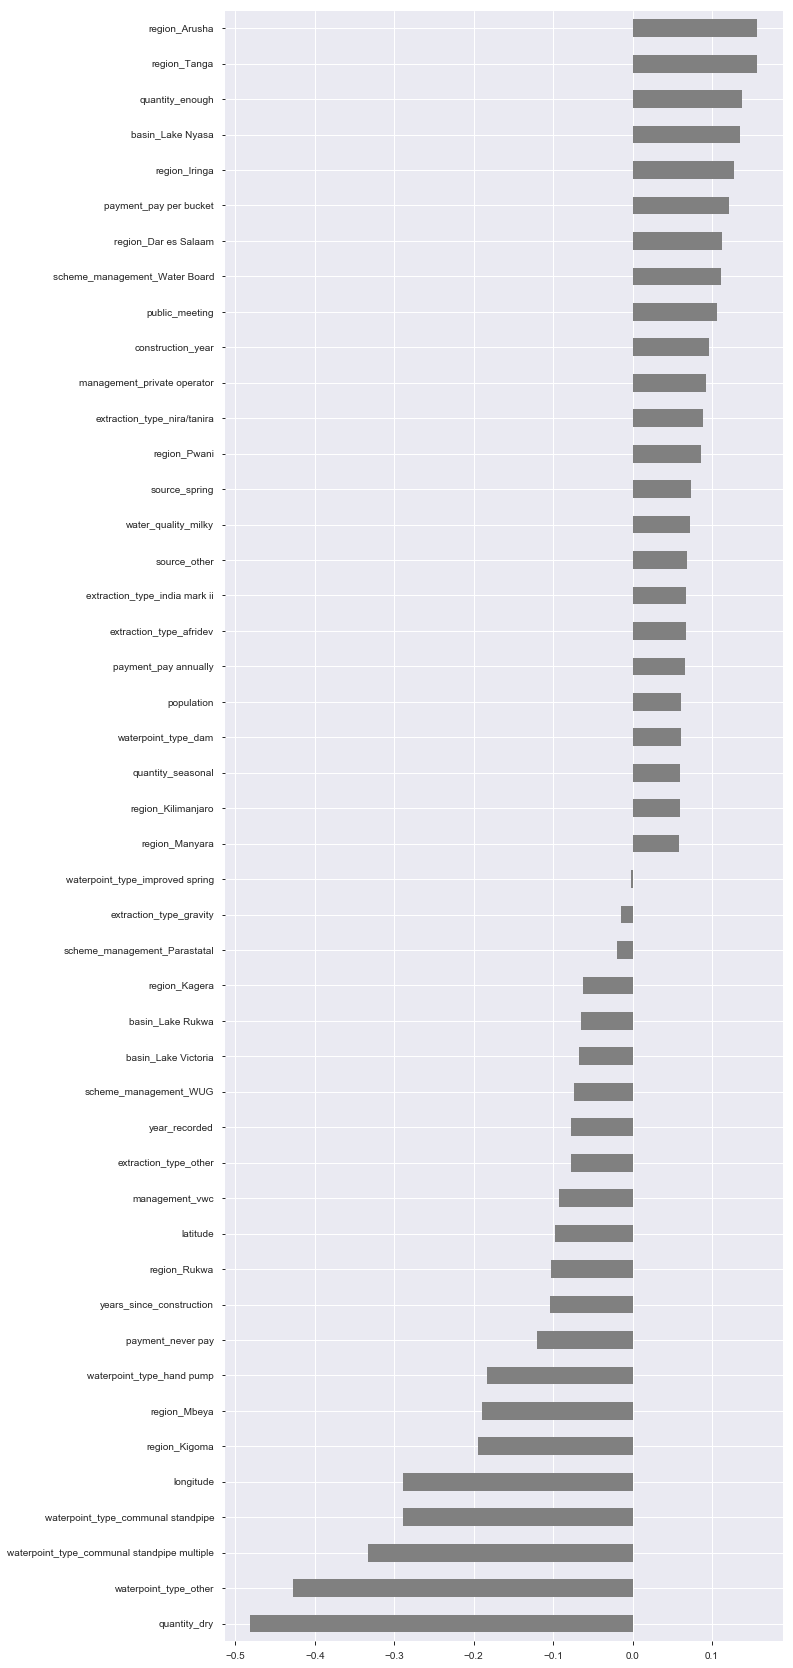

In [177]:
# Logistic regression using only features with absolute coefs in top 40%...

# Finding features with absolute coefs in top 40%...
coef_df = pd.DataFrame(model.coef_[0],
                       index=X_train_encoded.columns.tolist())
coef_df['abs_coef'] = coef_df[0].abs()
high_coef_features = coef_df[
    coef_df['abs_coef'] > coef_df['abs_coef'].quantile(.60)].index.tolist()

# Scaling data containing only features with absolute coefs in top 40%...
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded[high_coef_features])
X_val_scaled = scaler.transform(X_val_encoded[high_coef_features])
X_test_scaled = scaler.transform(X_test_encoded[high_coef_features])

# Fitting model on train data, scoring accuracy, predicting on test data...
model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting coefficients...
coefficients = pd.Series(model.coef_[0], high_coef_features)
plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.7230429292929293
Validation Accuracy Score: 0.7136363636363636


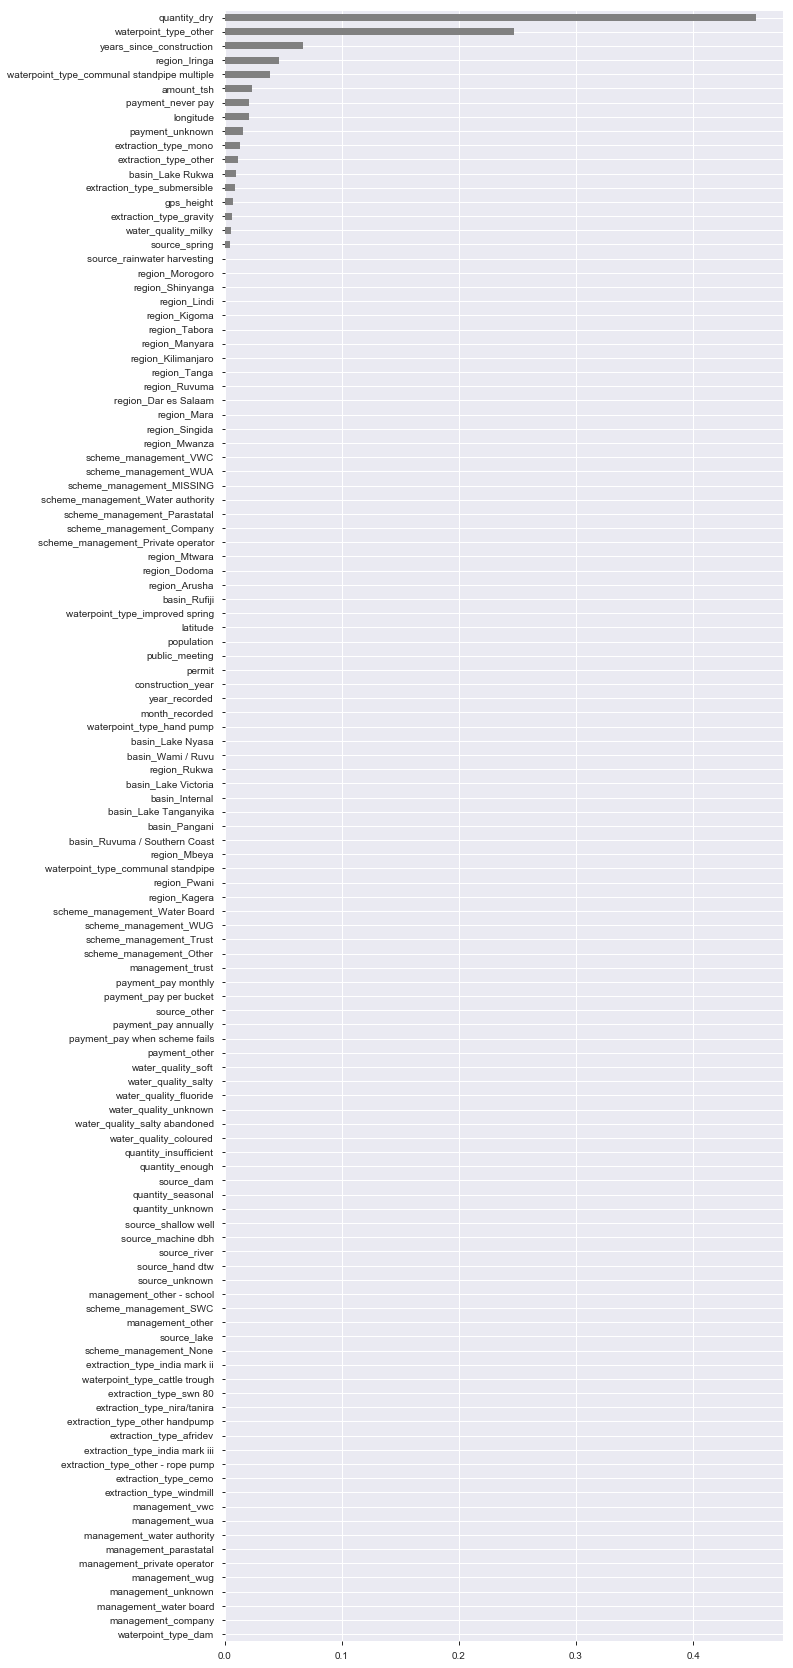

In [178]:
# Using a decision tree classifier and getting accuracy and importances...

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler

# Scaling data...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fitting model on train data, scoring accuracy, predicting on test data...
model = DecisionTreeClassifier(max_depth=8, max_leaf_nodes=24)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_,
                        X_train_encoded.columns.tolist())
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.7261153198653199
Validation Accuracy Score: 0.7134680134680135


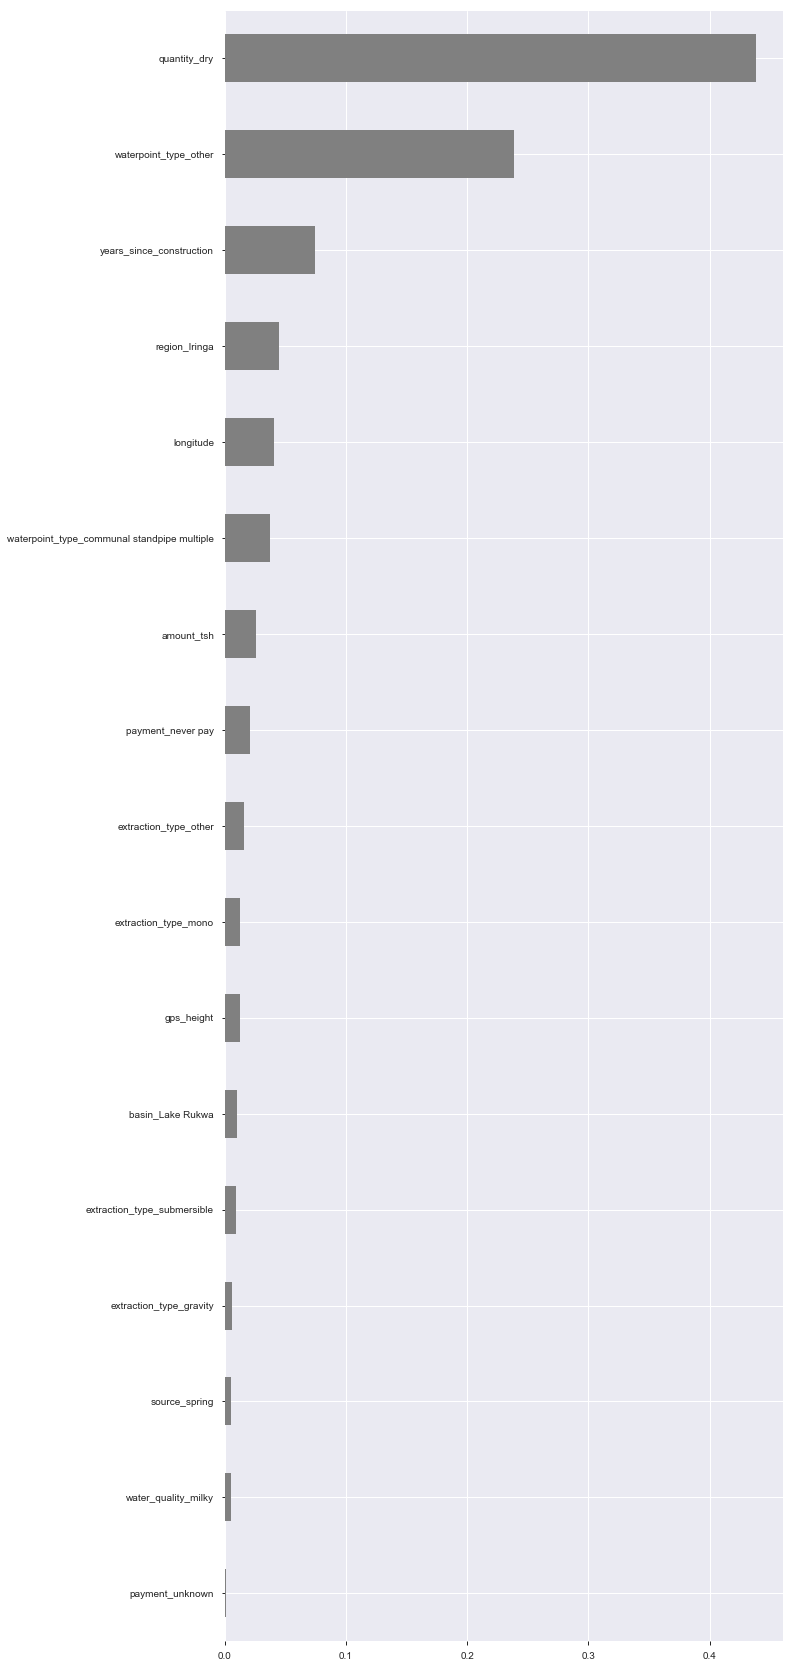

In [179]:
# Decision tree classifier using only features with non-zero importance...

# Finding features with non-zero importance...
importances_df = pd.DataFrame(model.feature_importances_,
                              index=X_train_encoded.columns.tolist())
important_features = importances_df[importances_df[0] > 0].index.tolist()

# Scaling data containing only important features...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded[important_features])
X_val_scaled = scaler.transform(X_val_encoded[important_features])
X_test_scaled = scaler.transform(X_test_encoded[important_features])

# Fitting model on train data, scoring accuracy, predicting on test data...
model = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=74)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_, important_features)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.9976430976430977
Validation Accuracy Score: 0.8037878787878788


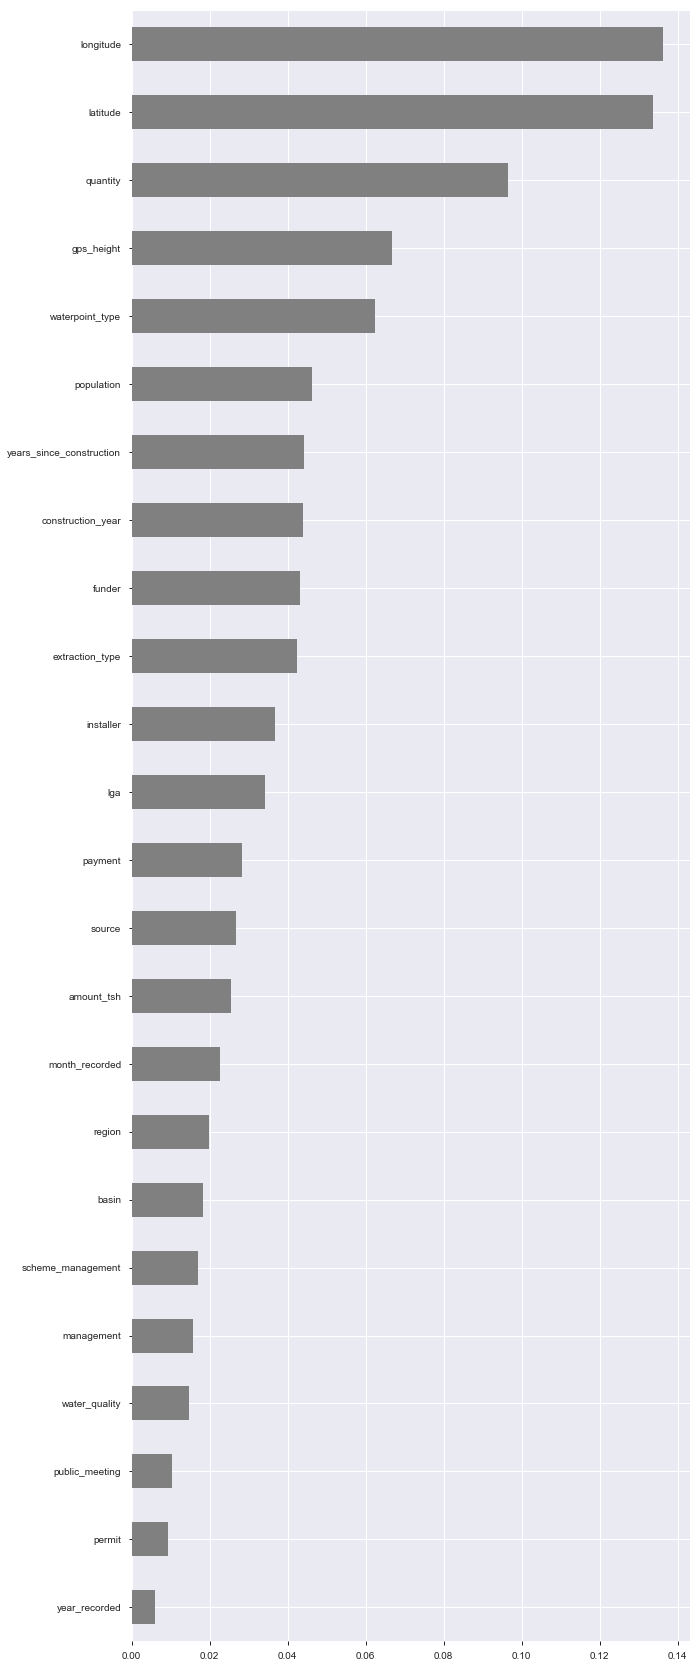

In [180]:
# Using a random forest classifier and getting accuracy and importances...

from sklearn.ensemble import RandomForestClassifier

# Using all categorical_features, not just ones of low cardinality...
categorical_features = train_features.select_dtypes(
    exclude='number').columns.tolist()
features = numeric_features + categorical_features

# Arranging data into X features matrix and y target vector ...
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

# Ordinal Encoding categorical features...
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

# Scaling data...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

# Fitting model on train data, scoring accuracy, predicting on test data...
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_,
                        X_train_encoded.columns.tolist())
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

Train Accuracy Score: 0.9976641414141414
Validation Accuracy Score: 0.8053030303030303


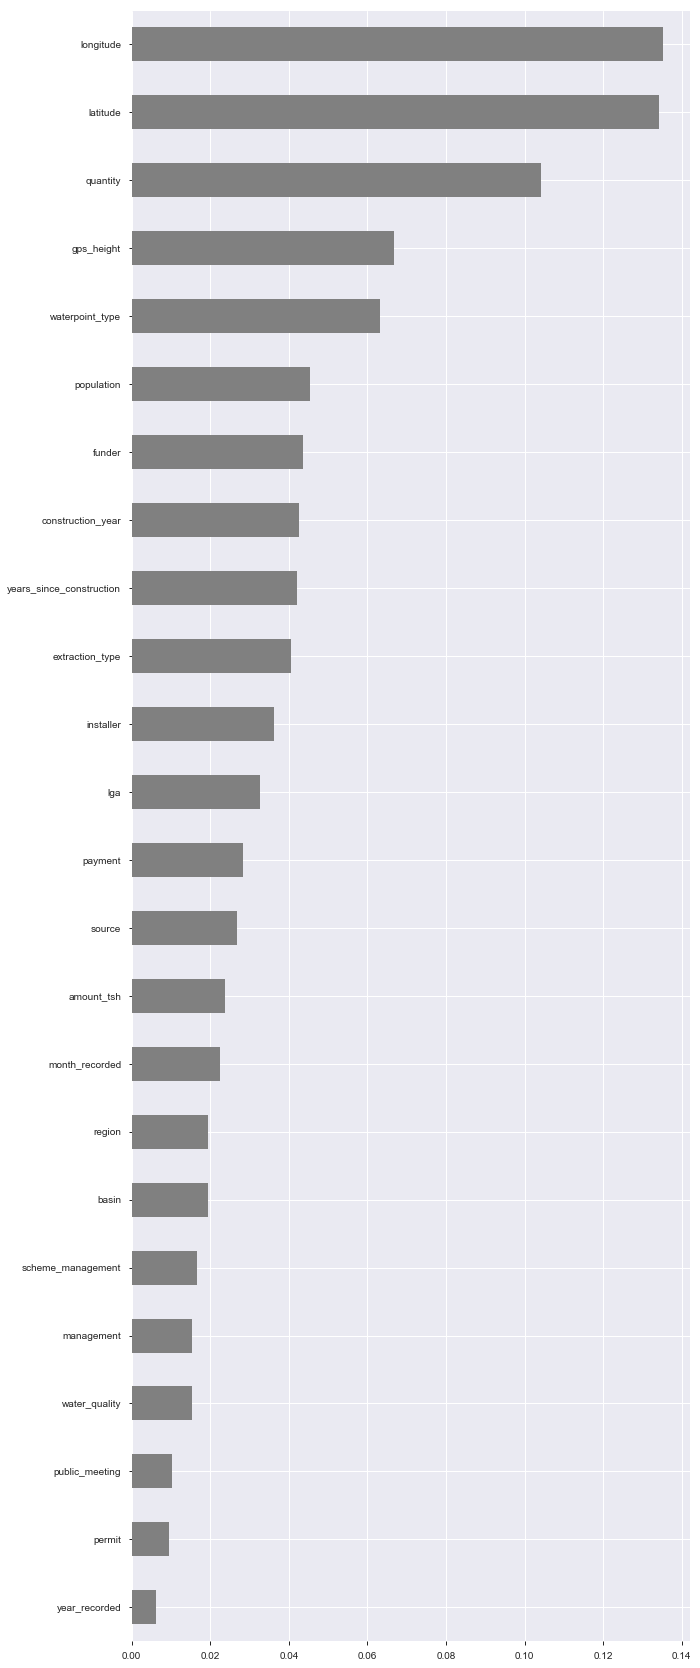

In [181]:
# Random forest classifier using only features with non-zero importance...

# Finding features with non-zero importance...
importances_df = pd.DataFrame(model.feature_importances_,
                              index=X_train_encoded.columns.tolist())
important_features = importances_df[importances_df[0] > 0].index.tolist()

# Scaling data containing only important features...
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded[important_features])
X_val_scaled = scaler.transform(X_val_encoded[important_features])
X_test_scaled = scaler.transform(X_test_encoded[important_features])

# Fitting model on train data, scoring accuracy, predicting on test data...
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_scaled, y_train)
print('Train Accuracy Score:', model.score(X_train_scaled, y_train))
print('Validation Accuracy Score:', model.score(X_val_scaled, y_val))
y_pred = model.predict(X_test_scaled)

# Plotting feature importances...
importances = pd.Series(model.feature_importances_, important_features)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

In [182]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('nathan_van_wyck_submission.csv', index=False)